# Santander Value Prediction Challenge

## Import all necessary directories

In [3]:
import os
print(os.listdir("../Santander"))

['model.txt', '.DS_Store', 'lgb_submission.csv', 'train_feat.txt', 'train_feat.npy', 'Santander Value Prediction Challenge.ipynb', 'test_feat.npy', '.ipynb_checkpoints', 'test.csv.zip', 'train.csv.zip']


In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns

## Basic look at the data

In [6]:
DATA_FOLDER = "../Santander"

train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv.zip'))
test  = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.zip'))

In [7]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


Some of the columns appear to be categorical, while others appear to be continuous
- The challenge focuses on insurance costs - these are probably various factors correlated to insurance costs. 
- All of the columns have ids, which means no information can be garned from the column titles

In [8]:
test.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y_train = train['target']
y_train.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

## Describing the target value
The target values have a few interesting factors:
- first, the percentiles have whole integers
- The mean is approximatly 6 million whereas the max is 40 million and the min is 3000
- These could refer to insurance payouts.

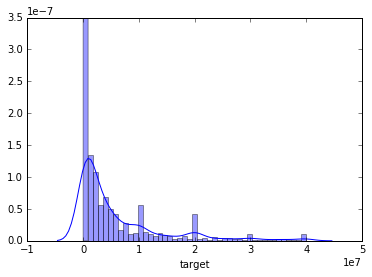

In [11]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
sns.distplot(y_train)

In [12]:
import statistics
print(statistics.mode(y_train))

2000000.0


## Preliminary analysis of features
There appear to be a lot of features, so some possibilities include feature dimensionality reductions.
First, lets took at the features without any feature reduction. 

In [9]:
train.columns

Index([u'ID', u'target', u'48df886f9', u'0deb4b6a8', u'34b15f335',
       u'a8cb14b00', u'2f0771a37', u'30347e683', u'd08d1fbe3', u'6ee66e115',
       ...
       u'3ecc09859', u'9281abeea', u'8675bec0b', u'3a13ed79a', u'f677d4d13',
       u'71b203550', u'137efaa80', u'fb36b89d9', u'7e293fbaf', u'9fc776466'],
      dtype='object', length=4993)

In [10]:
corrmat = train.corr()

All these features appear to be supremely uncorrelated with the target value. 

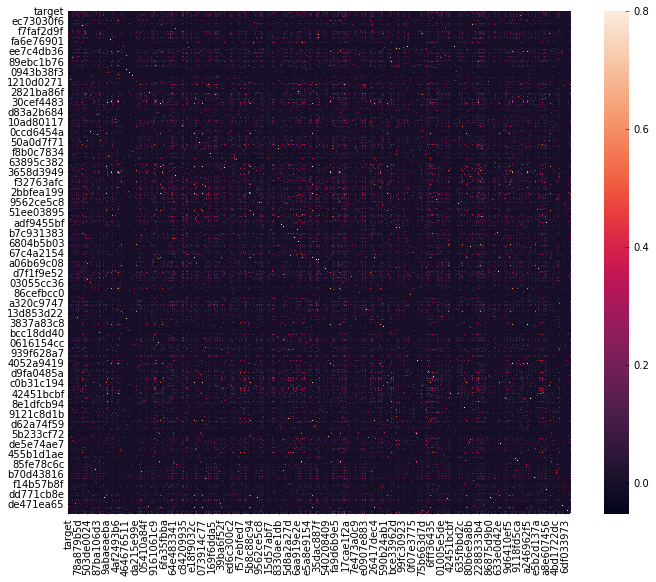

In [11]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

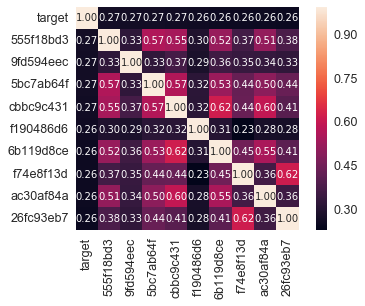

In [12]:
k = 10

# Obtain the values
target_correlated_column  = corrmat.nlargest(k, 'target')['target'].index
target_correlated_values = np.corrcoef(train[target_correlated_column].values.T)

# Obtain the graph
sns.set(font_scale=1.25)
hm = sns.heatmap(target_correlated_values, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=target_correlated_column.values, xticklabels=target_correlated_column.values)

plt.show()

In [13]:
corrmat_test = test.corr()

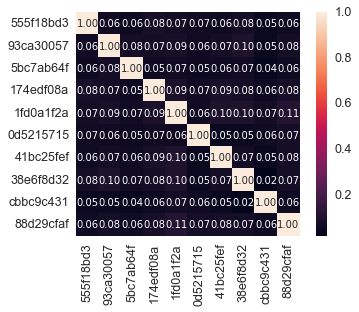

In [14]:
k = 10

# Obtain the values
test_correlated_column  = corrmat.nlargest(k, '555f18bd3')['555f18bd3'].index
test_correlated_values = np.corrcoef(test[test_correlated_column].values.T)

# Obtain the graph
sns.set(font_scale=1.25)
hm = sns.heatmap(test_correlated_values, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=test_correlated_column.values, xticklabels=test_correlated_column.values)

plt.show()

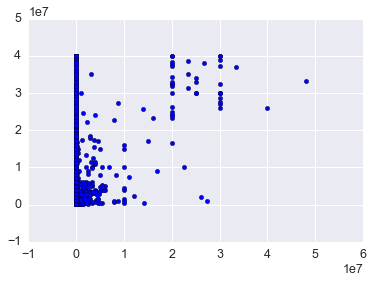

In [15]:
plt.scatter(x=train['555f18bd3'], y=y_train)

In [16]:
X_train_lgb = train.drop(["ID", "target"], axis=1)
y_train_log1p_lgb = np.log1p(train["target"].values)

X_test_lgb = test.drop(["ID"], axis=1)

## Looking at the features via feature importance
Correlation features have yielded no significant results, lets go look at it via feature importance

In [17]:
from sklearn.model_selection import train_test_split

develop_X, validation_X, develop_y, validation_y = train_test_split(X_train_lgb, y_train_log1p_lgb, test_size = 0.2, random_state = 42)

In [18]:
import lightgbm as lgb

In [19]:
import lightgbm as lgb

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [20]:
pred_test, model, evals_result = run_lgb(develop_X, develop_y, validation_X, validation_y, X_test_lgb)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 1.46025	valid_1's rmse: 1.51496
[300]	training's rmse: 1.2833	valid_1's rmse: 1.44614
[450]	training's rmse: 1.16789	valid_1's rmse: 1.42235
[600]	training's rmse: 1.08366	valid_1's rmse: 1.4136
[750]	training's rmse: 1.01814	valid_1's rmse: 1.4113
[900]	training's rmse: 0.966116	valid_1's rmse: 1.4108
Early stopping, best iteration is:
[908]	training's rmse: 0.963643	valid_1's rmse: 1.41069
LightGBM Training Completed...


In [21]:
model.save_model('model.txt')

In [ ]:
model = model

In [22]:
lgb_test = test.drop('ID', axis = 1)
y_pred_lgb = model.predict(lgb_test)

In [23]:
lgb_submission = pd.DataFrame({'ID': test.ID, 'target': y_pred_lgb})
# you could use any filename. We choose submission here
lgb_submission.to_csv('lgb_submission.csv', index=False)

Plot feature importances...


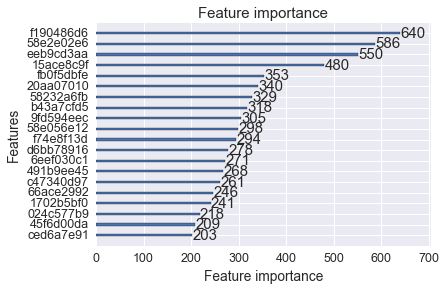

In [24]:
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

Plot metrics recorded during training...


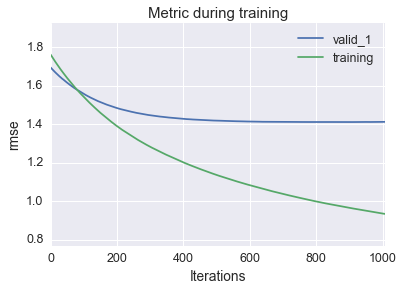

In [25]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

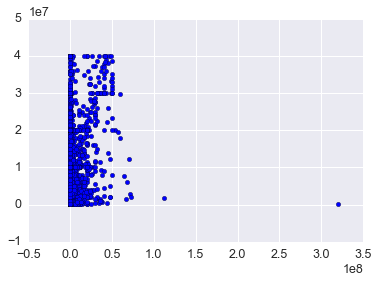

In [26]:
plt.scatter(x=train['f190486d6'], y=y_train)

In [27]:
train['log_f190486d6'] = np.log(train['f190486d6'])

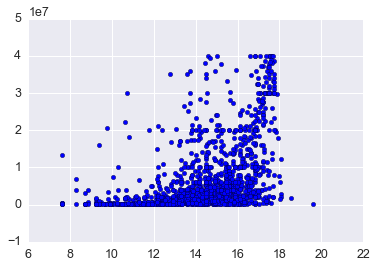

In [28]:
plt.scatter(x=train['log_f190486d6'], y=y_train)

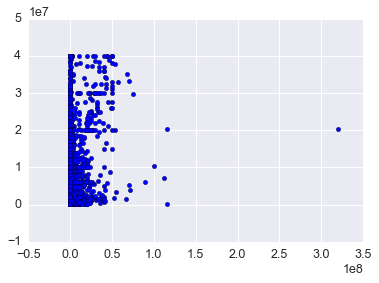

In [29]:
plt.scatter(x=train['58e2e02e6'], y=y_train)

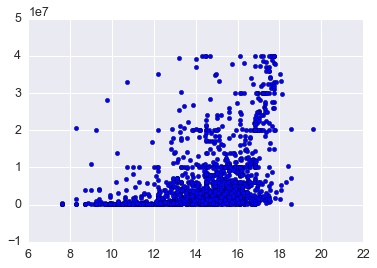

In [30]:
train['log_58e2e02e6'] = np.log(train['58e2e02e6'])
plt.scatter(x=train['log_58e2e02e6'], y=y_train)

In [31]:
lgb_feature_name = model.feature_name()
lgb_feature_importance = model.feature_importance()

In [32]:
print(lgb_feature_importance)
print(lgb_feature_name)

[0 0 0 ... 0 0 0]
[u'48df886f9', u'0deb4b6a8', u'34b15f335', u'a8cb14b00', u'2f0771a37', u'30347e683', u'd08d1fbe3', u'6ee66e115', u'20aa07010', u'dc5a8f1d8', u'11d86fa6a', u'77c9823f2', u'8d6c2a0b2', u'4681de4fd', u'adf119b9a', u'cff75dd09', u'96f83a237', u'b8a716ebf', u'6c7a4567c', u'4fcfd2b4d', u'f3b9c0b95', u'71cebf11c', u'd966ac62c', u'68b647452', u'c88d108c9', u'ff7b471cd', u'd5308d8bc', u'0d866c3d7', u'bc3f77679', u'bd8f989f1', u'0eff5bf95', u'22ed6dba3', u'92b13ebba', u'c330f1a67', u'233c7c17c', u'2cb4d123e', u'eeac16933', u'87ffda550', u'822e49b95', u'316b978cd', u'd04e16aed', u'5d5c5ce6d', u'ec863cb52', u'11ad148bd', u'ea18d720e', u'408d86ce9', u'69d8b4020', u'b0868a049', u'80b14398e', u'ecdef52b2', u'c36bcacc5', u'151d318cd', u'ab0cddb90', u'2d6bd8275', u'dfdf4b580', u'c87722678', u'a8c320153', u'7df8788e8', u'a04684f1f', u'fa977f17b', u'feed9d437', u'645b47cde', u'7298ca1ef', u'd80abf8bc', u'654dd8a3b', u'7fc39583c', u'8c94b6675', u'e421c414e', u'5b91580ee', u'964335fdf', u

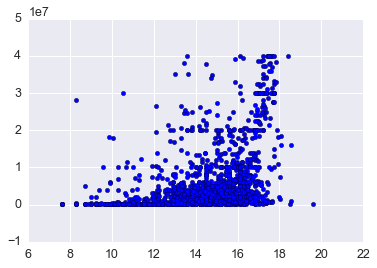

In [33]:
train['log_eeb9cd3aa'] = np.log(train['eeb9cd3aa'])
plt.scatter(x=train['log_eeb9cd3aa'], y=y_train)

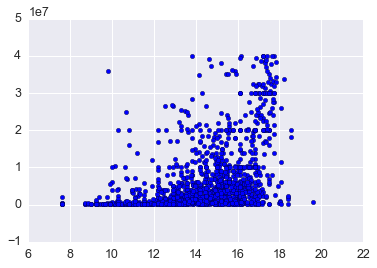

In [34]:
train['log_15ace8c9f'] = np.log(train['15ace8c9f'])
plt.scatter(x=train['log_15ace8c9f'], y=y_train)

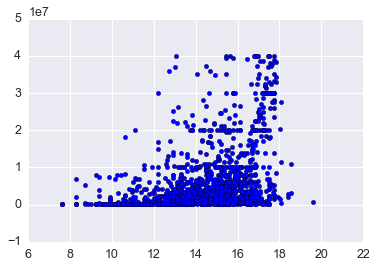

In [35]:
train['log_fb0f5dbfe'] = np.log(train['fb0f5dbfe'])
plt.scatter(x=train['log_fb0f5dbfe'], y=y_train)

In [36]:
X_train_lgb_log = train.drop(["ID", "target"], axis=1)
y_train_log1p_lgb_log = np.log1p(train["target"].values)

X_test_lgb_log = test.drop(["ID"], axis=1)

from sklearn.model_selection import train_test_split

develop_X, validation_X, develop_y, validation_y = train_test_split(X_train_lgb, y_train_log1p_lgb, test_size = 0.2, random_state = 42)

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

pred_test_2, model_2, evals_result_2 = run_lgb(develop_X, develop_y, validation_X, validation_y, X_test_lgb)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 1.46025	valid_1's rmse: 1.51496
[300]	training's rmse: 1.2833	valid_1's rmse: 1.44614
[450]	training's rmse: 1.16789	valid_1's rmse: 1.42235
[600]	training's rmse: 1.08366	valid_1's rmse: 1.4136
[750]	training's rmse: 1.01814	valid_1's rmse: 1.4113
[900]	training's rmse: 0.966116	valid_1's rmse: 1.4108
Early stopping, best iteration is:
[908]	training's rmse: 0.963643	valid_1's rmse: 1.41069
LightGBM Training Completed...


In [15]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:15])

Features Importance...
        feature      gain  split
4358  f190486d6  8.403634    640
2500  58e2e02e6  5.001093    586
3660  eeb9cd3aa  4.199893    550
4243  15ace8c9f  3.096444    480
2755  9fd594eec  2.756506    305
8     20aa07010  2.080284    340
3771  58232a6fb  1.455217    329
878   6eef030c1  1.325721    271
1530  b43a7cfd5  1.133338    318
3866  491b9ee45  1.034529    268
2835  fb0f5dbfe  1.025635    353
1556  024c577b9  1.003526    218
4581  1702b5bf0  0.855859    241
594   66ace2992  0.841943    246
4084  2288333b4  0.838447    155


In [13]:
model = lgb.Booster(model_file='model.txt')

## Feature Generation
We will generate features in a few main ways

### 1) Feature interaction 

### 2) Mean Encodings

### 3) Dimensionality reduction 

In [16]:
for idx_1,row in featureimp[:20].iterrows():
    feature_1 = featureimp.loc[idx_1].feature
    print(feature_1)
    for idx_2,row in featureimp[:15].iterrows():
        feature_2 = featureimp.loc[idx_2].feature
        print(feature_2)
        
        train[feature_1 + '_' + feature_2] = train[feature_1]*train[feature_2]
        test[feature_1 + '_' + feature_2]  = test[feature_1]*test[feature_2]





f190486d6
f190486d6
58e2e02e6
eeb9cd3aa
15ace8c9f
9fd594eec
20aa07010
58232a6fb
6eef030c1
b43a7cfd5
491b9ee45
fb0f5dbfe
024c577b9
1702b5bf0
66ace2992
2288333b4
58e2e02e6
f190486d6
58e2e02e6
eeb9cd3aa
15ace8c9f
9fd594eec
20aa07010
58232a6fb
6eef030c1
b43a7cfd5
491b9ee45
fb0f5dbfe
024c577b9
1702b5bf0
66ace2992
2288333b4
eeb9cd3aa
f190486d6
58e2e02e6
eeb9cd3aa
15ace8c9f
9fd594eec
20aa07010
58232a6fb
6eef030c1
b43a7cfd5
491b9ee45
fb0f5dbfe
024c577b9
1702b5bf0
66ace2992
2288333b4
15ace8c9f
f190486d6
58e2e02e6
eeb9cd3aa
15ace8c9f
9fd594eec
20aa07010
58232a6fb
6eef030c1
b43a7cfd5
491b9ee45
fb0f5dbfe
024c577b9
1702b5bf0
66ace2992
2288333b4
9fd594eec
f190486d6
58e2e02e6
eeb9cd3aa
15ace8c9f
9fd594eec
20aa07010
58232a6fb
6eef030c1
b43a7cfd5
491b9ee45
fb0f5dbfe
024c577b9
1702b5bf0
66ace2992
2288333b4
20aa07010
f190486d6
58e2e02e6
eeb9cd3aa
15ace8c9f
9fd594eec
20aa07010
58232a6fb
6eef030c1
b43a7cfd5
491b9ee45
fb0f5dbfe
024c577b9
1702b5bf0
66ace2992
2288333b4
58232a6fb
f190486d6
58e2e02e6
eeb9cd3aa


In [18]:
print(train.shape)
print(test.shape)

(4459, 5293)
(49342, 5292)


In [22]:
X_train_lgb_feat = train.drop(["ID", "target"], axis=1)
y_train_lgb_feat = np.log1p(train["target"].values)

X_test_lgb_feat = test.drop(["ID"], axis=1)

from sklearn.model_selection import train_test_split

develop_X, validation_X, develop_y, validation_y = train_test_split(X_train_lgb_feat, y_train_lgb_feat, test_size = 0.2, random_state = 42)

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

pred_test_2, model_2, evals_result_2 = run_lgb(develop_X, develop_y, validation_X, validation_y, X_test_lgb_feat)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 1.45647	valid_1's rmse: 1.51523
[300]	training's rmse: 1.28022	valid_1's rmse: 1.45223
[450]	training's rmse: 1.16312	valid_1's rmse: 1.42969
[600]	training's rmse: 1.0786	valid_1's rmse: 1.42157
[750]	training's rmse: 1.01388	valid_1's rmse: 1.41964
[900]	training's rmse: 0.961319	valid_1's rmse: 1.41966
Early stopping, best iteration is:
[825]	training's rmse: 0.986258	valid_1's rmse: 1.41909
LightGBM Training Completed...


### Now, lets try visualizing the dataset by feature decomposition.


In [23]:
from sklearn.decomposition import PCA

def pca_trials(n_comp):
    pca = PCA(n_components = n_comp)
    pca_result = pca.fit_transform(X_train_lgb_feat)
    
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [24]:
for i in range(10):
    pca_trials(i)

Explained variation per principal component: []
Explained variation per principal component: [0.21975005]
Explained variation per principal component: [0.21975005 0.06396026]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885 0.06217796]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885 0.06217796 0.06090593]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885 0.06217796 0.06090593 0.05983651]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885 0.06217796 0.06090593 0.05983651
 0.05962757]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885 0.06217796 0.06090593 0.05983651
 0.05962757 0.05898703]
Explained variation per principal component: [0.21975005 0.06396026 0.06241885 0.06217796 0.06090593 0.05983651
 0.05962757 0.05898703 0.05883758]


In [29]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_lgb_feat)

X_train_lgb_feat['pca_one'] = pca_result[:,0]
X_train_lgb_feat['pca_two'] = pca_result[:,1] 
X_train_lgb_feat['pca_three'] = pca_result[:,2]

In [34]:
import time

from sklearn.manifold import TSNE


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train_lgb_feat)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4459 samples in 1.111s...
[t-SNE] Computed neighbors for 4459 samples in 101.982s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4459
[t-SNE] Computed conditional probabilities for sample 2000 / 4459
[t-SNE] Computed conditional probabilities for sample 3000 / 4459
[t-SNE] Computed conditional probabilities for sample 4000 / 4459
[t-SNE] Computed conditional probabilities for sample 4459 / 4459
[t-SNE] Mean sigma: 382041.190659
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.906265
[t-SNE] Error after 300 iterations: 2.170387
t-SNE done! Time elapsed: 164.608153105 seconds


In [35]:
X_train_lgb_feat['tsne_one'] = tsne_results[:,0]
X_train_lgb_feat['tsne_two'] = tsne_results[:,1]